In [1]:
import pandas as pd,os
# ,SenaoDB
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
db=SenaoDB.DB()
conn=db._conn

In [3]:
os.chdir(r'C:\Users\018363\Project\20240306_推薦系統HDBSCAN')

In [4]:
sql="""
select * from ptest.Group_recommend_result 
order by second_cat::int  asc
"""
df=pd.read_sql(sql,conn)

C:\Users\018363\AppData\Local\Temp\ipykernel_13248\1560727203.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df=pd.read_sql(sql,conn)


In [5]:
df.head()

,main_cat,second_cat,mart_code,mart_name,mart_status,qty,seq,created_by,creation_date
0,hdbscan,-1,1343144,Concern康生 輕盈按摩披肩 藍色 CON-162,2,2,100,ETL,2024-03-18 17:10:21.177316
1,hdbscan,-1,1252158,【週期購】sakuyo 金盞花萃取葉黃素軟膠囊(30粒/瓶),2,38,13,ETL,2024-03-18 17:10:21.177316
2,hdbscan,-1,1292823,【週期購】sakuyo每日青汁(30入/盒),2,27,14,ETL,2024-03-18 17:10:21.177316
3,hdbscan,-1,1339702,【週期購】sakuyo 比菲德氏菌+半乳寡醣(30條/盒),2,26,15,ETL,2024-03-18 17:10:21.177316
4,hdbscan,-1,1344730,SAMSUNG Galaxy S23 5G SM-S9110 8G/128G 白【S級福利品...,2,21,16,ETL,2024-03-18 17:10:21.177316


In [ ]:
# [set(df[df['second_cat']==i]['mart_code']) for i in df['second_cat'].unique()]

In [ ]:
# df['second_cat'].unique()

In [7]:
def iou(set1, set2):
    # 計算兩個商品編號清單的 IOU
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    iou_value = intersection / union if union != 0 else 1  # 將 union 為 0 時的情況改為 1
    return iou_value

item_sets=[set(df[df['second_cat']==i]['mart_code']) for i in df['second_cat'].unique()]

# 計算兩兩相似度的 IOU
num_items = len(item_sets)
iou_matrix_result = np.zeros((num_items, num_items))

for i in range(num_items):
    for j in range(num_items):
        iou_matrix_result[i, j] = iou(item_sets[i], item_sets[j])

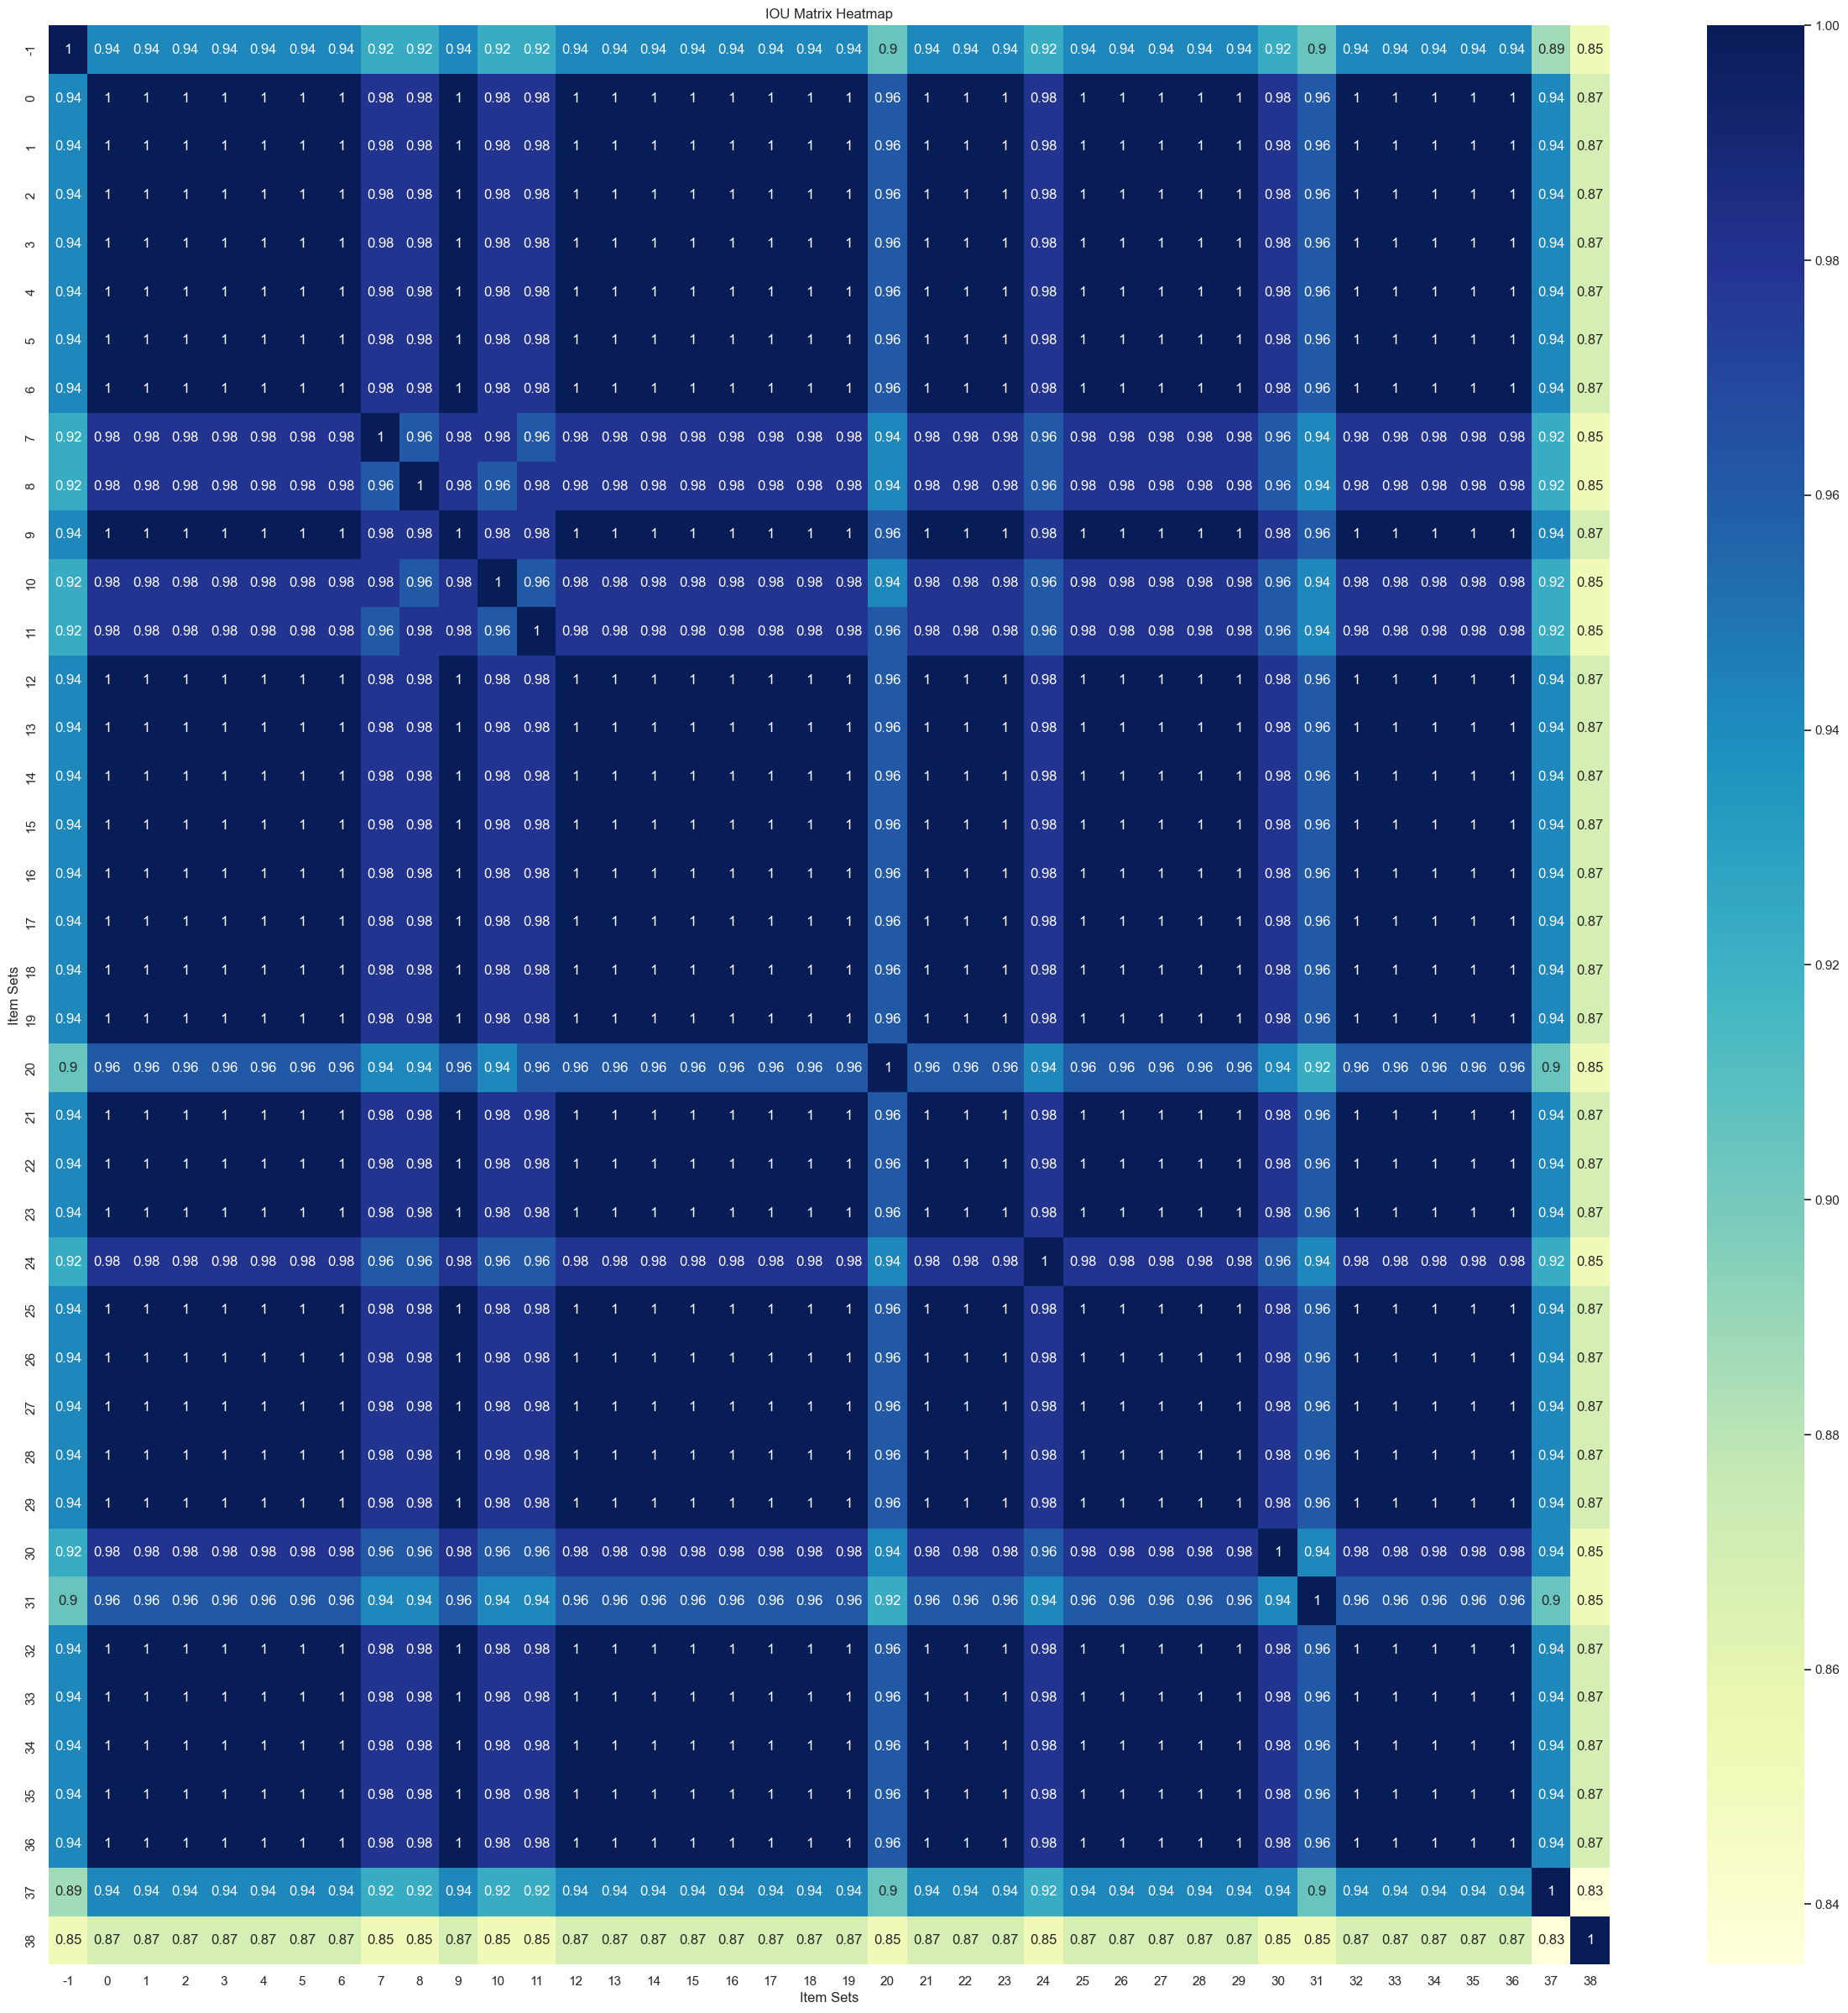

In [8]:
# 使用 seaborn 創建熱視圖
sns.set()
plt.figure(figsize=(30, 30))
sns.heatmap(iou_matrix_result, annot=True, cmap="YlGnBu",
            xticklabels=list(df['second_cat'].unique()),
            yticklabels=list(df['second_cat'].unique())
           )
plt.title('IOU Matrix Heatmap')
plt.xlabel('Item Sets')
plt.ylabel('Item Sets')
filename='包含遞補賣場.png'
plt.savefig(filename)
plt.show()

# 排除遞補的賣場，看相似度

In [9]:
sql="""
select * from ptest.Group_recommend_result_nofillup 
order by second_cat::int  asc
"""
df1=pd.read_sql(sql,conn)

C:\Users\018363\AppData\Local\Temp\ipykernel_13248\2548673600.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df1=pd.read_sql(sql,conn)


In [11]:
#觀察各群人數以及推薦賣場數量
sql="""
with t as (
SELECT "Group",count(*) as member_cnt from ptest."anio_hdbscan_result" 
group by "Group"
)select t.*,coalesce(B.mart_cnt,0) from t
left join (
select second_cat,count(mart_code) as mart_cnt from ptest.Group_recommend_result_nofillup 
group by second_cat
) B on t."Group"=B.second_cat
order by t."Group"::int asc
"""
tp=pd.read_sql(sql,conn)
tp

C:\Users\018363\AppData\Local\Temp\ipykernel_13248\210615479.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  tp=pd.read_sql(sql,conn)


,Group,member_cnt,coalesce
0,-1,1462981,69
1,0,464203,15
2,1,25502,20
3,2,10183,10
4,3,67,27
5,4,32,7
6,5,595,79
7,6,999,6
8,7,1726,54
9,8,2028,10


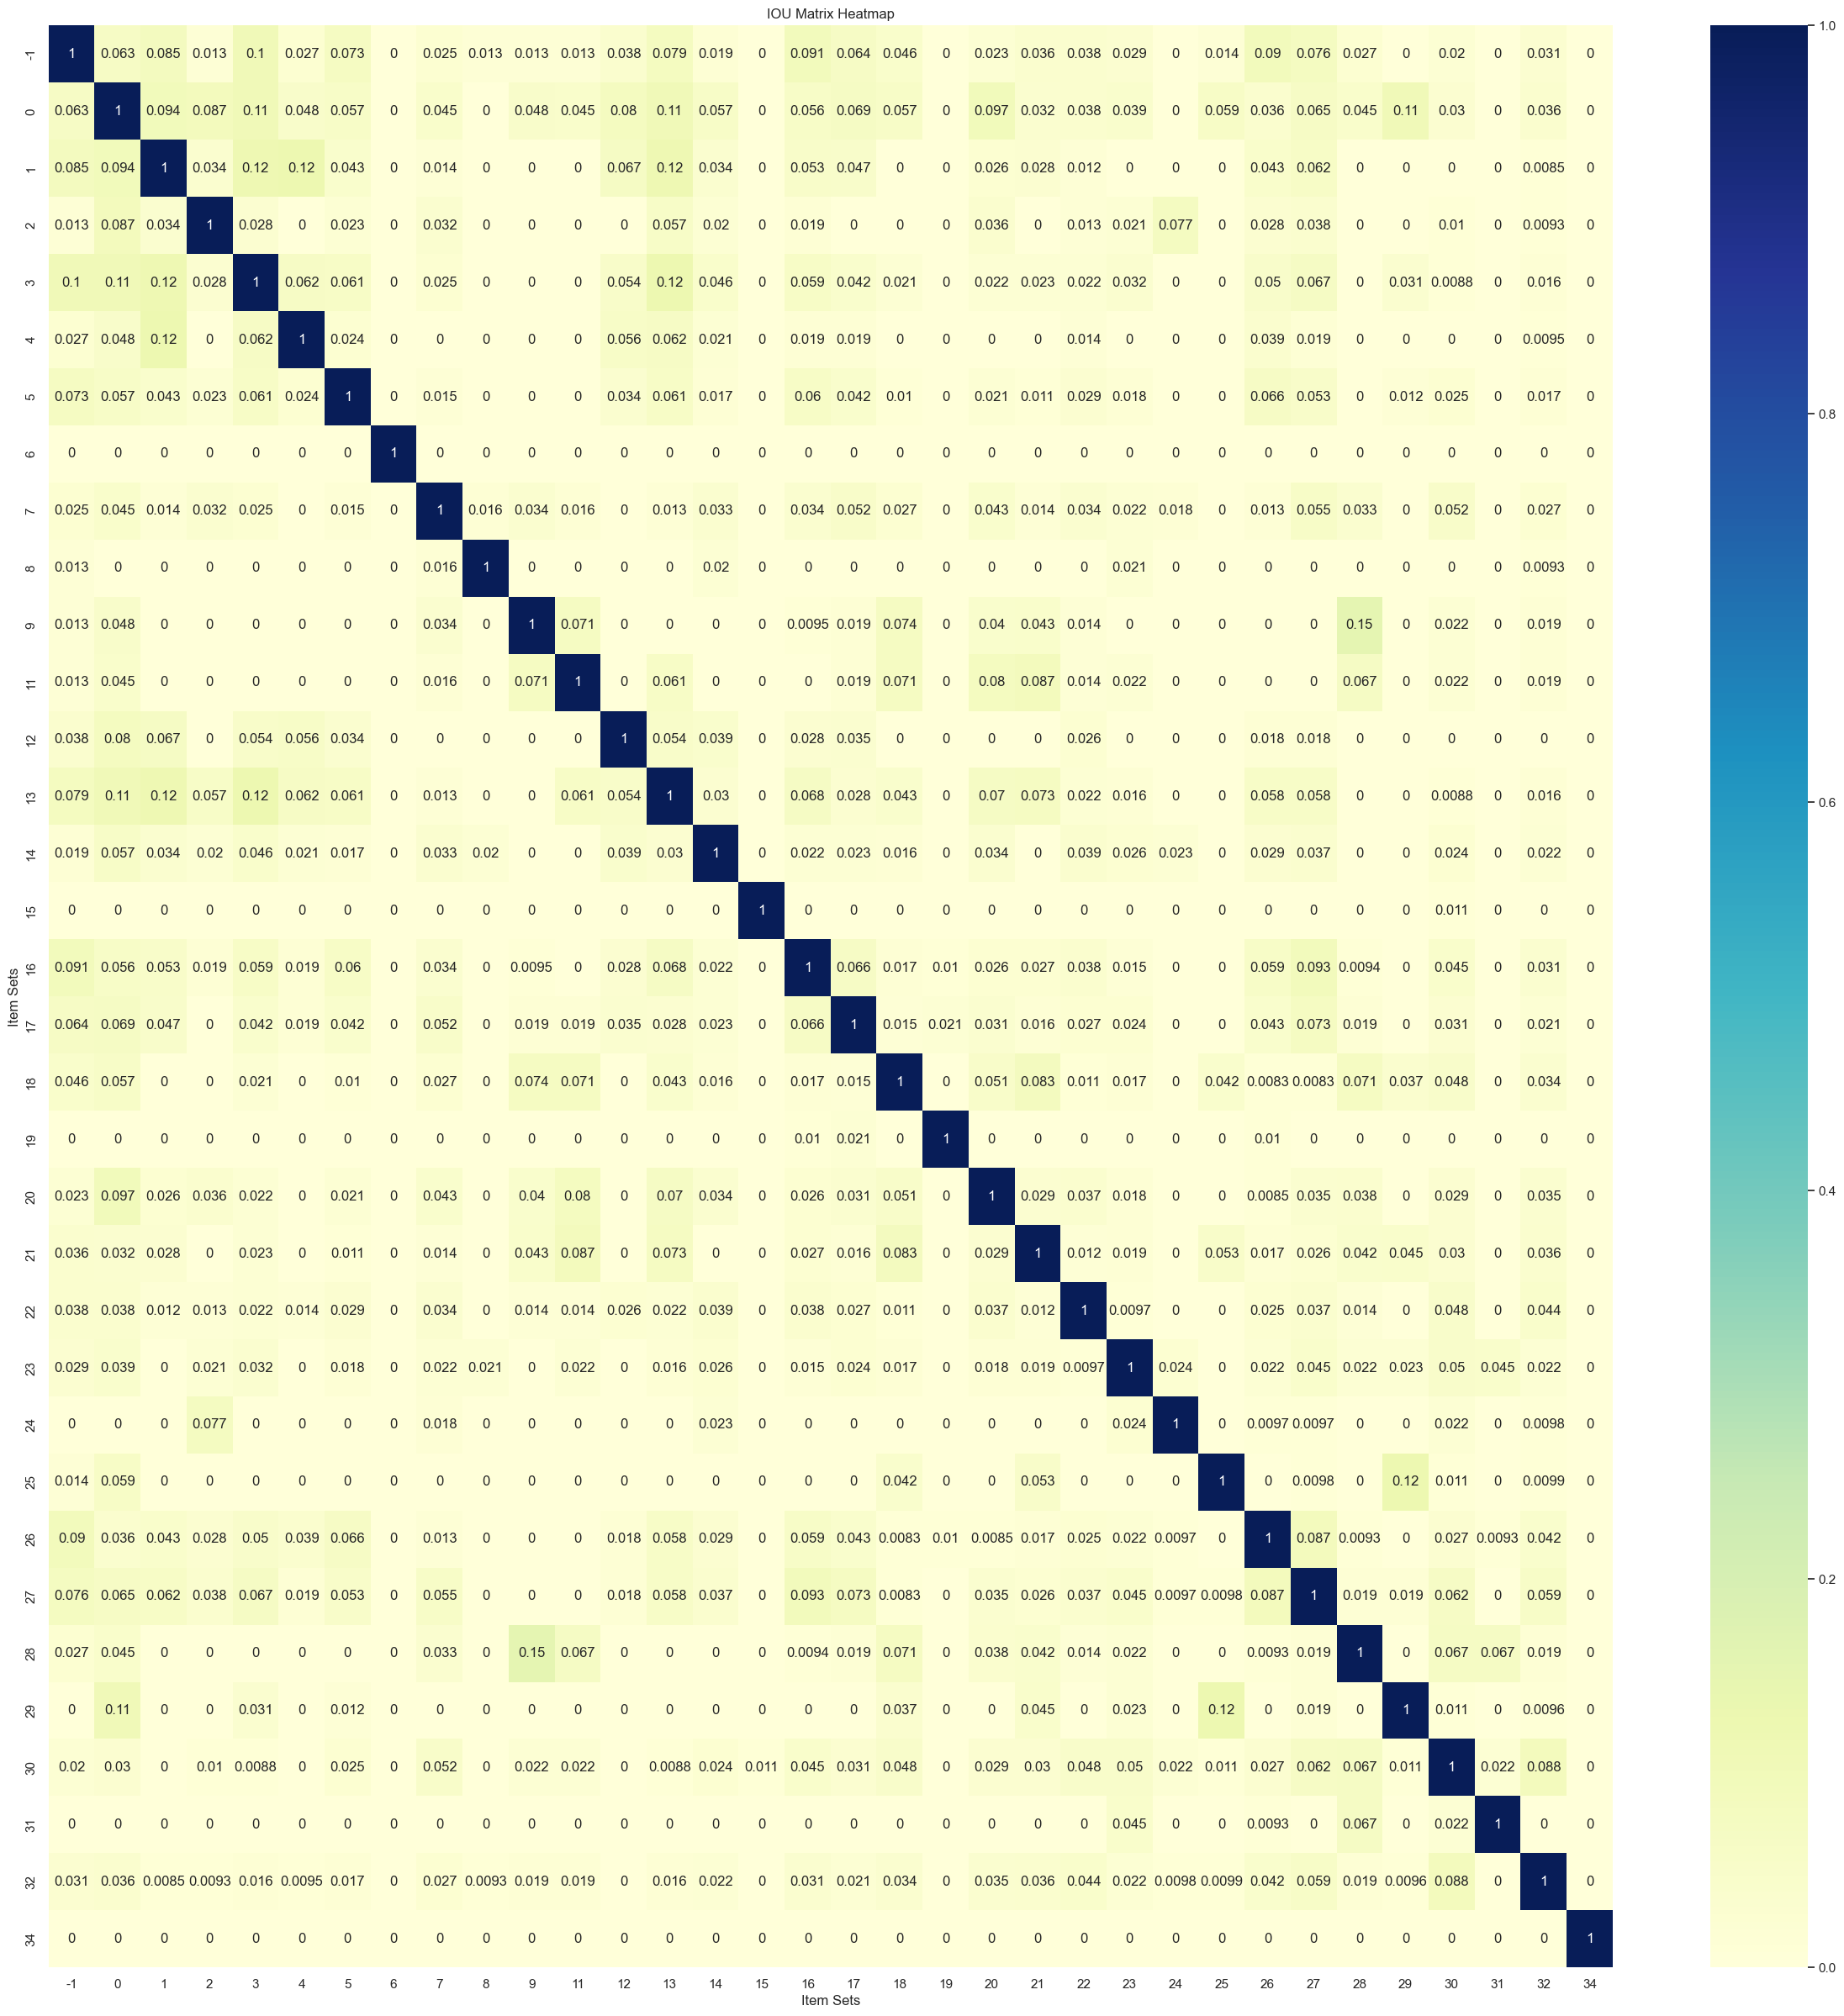

In [12]:
item_sets=[set(df1[df1['second_cat']==i]['mart_code']) for i in df1['second_cat'].unique()]

# 計算兩兩相似度的 IOU
num_items = len(item_sets)
iou_matrix_result = np.zeros((num_items, num_items))

for i in range(num_items):
    for j in range(num_items):
        iou_matrix_result[i, j] = iou(item_sets[i], item_sets[j])

# 使用 seaborn 創建熱視圖
sns.set()
plt.figure(figsize=(30, 30))
sns.heatmap(iou_matrix_result, annot=True, cmap="YlGnBu", 
            xticklabels=list(df1['second_cat'].unique()),
            yticklabels=list(df1['second_cat'].unique())
           )
plt.title('IOU Matrix Heatmap')
plt.xlabel('Item Sets')
plt.ylabel('Item Sets')

filename='未遞補.png'
plt.savefig(filename)
plt.show()

In [ ]:
#觀察指定群的賣場
# df1[df1['second_cat']=='34']

In [ ]:
# iou(item_sets[33], item_sets[5])

In [ ]:
# item_sets[33]